In [2]:
import pandas as pd
import matplotlib.pyplot as plt
url = "./mushrooms.csv"
dataset = pd.read_csv(url)
dataset.head(10)

for column in dataset.columns[1:]:
    unics = dataset[column].unique()
    transform = {unic:i+1 for i, unic in enumerate(dataset[column].unique())}
    dataset[column] = dataset[column].apply(lambda x: transform[x])

transform = {"e":0, "p":1}
dataset["class"] = dataset["class"].apply(lambda x: transform[x])
dataset.head(10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,1,1,2,1,2,1,1,2,1,...,1,1,1,1,1,1,1,2,2,2
2,0,2,1,3,1,3,1,1,2,2,...,1,1,1,1,1,1,1,2,2,3
3,1,1,2,3,1,1,1,1,1,2,...,1,1,1,1,1,1,1,1,1,1
4,0,1,1,4,2,4,1,2,2,1,...,1,1,1,1,1,1,2,2,3,2
5,0,1,2,2,1,2,1,1,2,2,...,1,1,1,1,1,1,1,1,2,2
6,0,2,1,3,1,2,1,1,2,3,...,1,1,1,1,1,1,1,1,2,3
7,0,2,2,3,1,3,1,1,2,2,...,1,1,1,1,1,1,1,2,1,3
8,1,1,2,3,1,1,1,1,1,4,...,1,1,1,1,1,1,1,1,4,2
9,0,2,1,2,1,2,1,1,2,3,...,1,1,1,1,1,1,1,1,1,3


In [4]:
import numpy as np


class Linear:
    def __init__(self, in_neurons, out_neurons, activ_func = "sigmoid", lr=0.03):
        self.in_neurons = in_neurons
        self.out_neurons = out_neurons
        self.activ_func = { "None": lambda x : x,
                           "sigmoid" : lambda x: 1 / (1 + np.exp(-x)),
                            "softmax": self.softmax
                            }.get(activ_func, "sigmoid")
        
        self.activ_func_name = activ_func
        self.lr = lr
        self.W = np.random.random_sample((self.out_neurons, self.in_neurons))-0.5
        self.b = np.random.random_sample(out_neurons)+0.001
        self.X = None
        self.output = None

    def softmax(self, y_pred):
        #Решаем проблему огромных экспонент
        exp_pred = np.exp(y_pred - np.max(y_pred, axis=1, keepdims=True))
        return exp_pred / np.sum(exp_pred, axis=1, keepdims=True)

    def activ_grad(self, outgrad):
        if self.activ_func_name == "sigmoid":
            return (1-self.output) * self.output
        
        elif self.activ_func_name =="softmax":
            n = self.output.shape[1]
            trans_axes = (0, 2, 1)
            y_new = np.tile(self.output[:, :, np.newaxis], (1, 1, n))

            return np.matmul(
                     (np.identity(n)[np.newaxis,:]  - np.transpose(y_new, axes = trans_axes)) * y_new, 
                      np.transpose(outgrad[:, np.newaxis], axes = trans_axes)
                      ).squeeze()
        return 1

    def forward(self, X):
        self.X = X
        self.output = self.activ_func(np.dot(X, self.W.T) + self.b)
        return self.output.copy()
    
    def backward(self, out_grad):

        if self.activ_func_name != "softmax":
            out_grad = out_grad * self.activ_grad(out_grad)
        else:
            out_grad = self.activ_grad(out_grad)
            
        back_grad = np.dot(out_grad, self.W)
        self.b -= np.sum(out_grad, axis=0) * self.lr
        self.W -= np.dot(out_grad.T, self.X) * self.lr
        return back_grad


class MLP:
    def __init__(self, n_per_layer:list, num_classes:int, active_funcs_per_layer:dict = {0: "None"}, lr:float=0.03, diff_funcs = False, mixing = True ):
        self.layers = [n_layer for n_layer in n_per_layer] + [num_classes]
        self.mixing = mixing
        self.num_classes = num_classes

        if diff_funcs == True:
            self.active_funcs = []
            flag = active_funcs_per_layer.get(0)

            for i in range(len(self.layers) - 1):
                flag = active_funcs_per_layer.get(i, flag)
                self.active_funcs.append(flag)
            
        else:
            self.active_funcs = [active_funcs_per_layer.get(0) for i in range(len(self.layers)-2)] + ["softmax"]
        
        self.layers = [Linear(self.layers[i], self.layers[i+1], activ_func=self.active_funcs[i], lr=lr) for i in range(len(self.layers) - 1)]


    def preload_y(self, y_true):
        otv = np.zeros((y_true.shape[0], self.num_classes))
        otv[np.arange(otv.shape[0]), y_true] += 1
        return otv
    

    def categirical_crossentropy(self, y_pred, y_true):
        y_true = self.preload_y(y_true)

        cross_ent = - y_true * np.log(y_pred)
        grad = y_pred - y_true
        return cross_ent, grad
    
    
    
    def predict_proba(self, X):
        now_x = X.copy()
        for layer in self.layers:
            now_x = layer.forward(now_x)
        
        return now_x
    
    

    def train(self, X, y, batch_size):
        if batch_size > y.shape[0]:
            return -1
        
        losses = 0 
        if self.mixing:
            indices = np.random.permutation(X.shape[0])
            X = X[indices]
            y = y[indices]

        #Данный блок отвечает за прямое распространение и подсчёт итоговой ошибки на батче
        #================================================================
        for batch_x in range(batch_size, X.shape[0], batch_size):
            now_x = X[batch_x - batch_size: batch_x]
            y_softmax = self.predict_proba(now_x)

            batch_loss, otv_grad = self.categirical_crossentropy(y_softmax, y[batch_x - batch_size: batch_x])
            #================================================================


            #Данынй блок - изменение параметров весов нейронки
            #================================================================
            for layer in reversed(self.layers):
                # print("ACTIVATE", layer.activ_func)
                otv_grad = layer.backward(otv_grad)
            #================================================================

            losses+=np.sum(batch_loss)
        
        print(f"Average_loss for EPOCH is: {losses/y.shape[0]:>7f}")




    def test(self, X, y):
        y_softmax = self.predict_proba(X)

        loss, _ = self.categirical_crossentropy(y_softmax, y)
        self.pre_rec_f1(y, np.argmax(y_softmax, axis=1))
        print(f"TEST Average LOSS IS: {np.sum(loss)/y.shape[0]}")
        


    def pre_rec_f1(self, y_true, y_pred):
        precision_list = []
        recall_list = []
        f1_list = []
        for i in np.unique(y_true):

            tp = np.sum((y_pred == i) * (y_true == i))
            fp = np.sum((y_pred==i) * (y_true != i))
            fn = np.sum((y_pred!=i) * (y_true == i))
            precision = tp/max(tp+fp, 1)
            recall = tp/max(tp+fn, 1)
            f1 = 2*precision*recall/max((precision+recall, 0.000001))

            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
        
        print(f"Macro precision = {sum(precision_list)/len(precision_list)}")
        print(f"Macro recall = {sum(recall_list)/len(recall_list)}")
        print(f"Macro f1 = {sum(f1_list)/len(f1_list)}")
        print(f"accuracy = {np.sum(y_pred==y_true)/y_true.shape[0]}")

In [14]:
from sklearn.model_selection import train_test_split
X = dataset[dataset.columns[1:]].to_numpy()
y = dataset["class"].to_numpy()

x_train, x_test, y_train1, y_test1 = train_test_split(X, y, test_size=0.2)

clf = MLP(n_per_layer=(22,10,5), num_classes=2, lr=0.00003)

for i in range(100):
    if i%100 == 0:
        print(f"EPOCH {i} start.")

    clf.train(x_train, y_train1, batch_size=100)
    
    if (i + 1) %10 == 0:
        clf.test(x_test, y_test1)
        print(f"EPOCH {i} end.\n ======================\n\n\n\n======================")

otv = clf.predict_proba(x_test)

EPOCH 0 start.
Average_loss for EPOCH is: 0.749140
Average_loss for EPOCH is: 0.667710
Average_loss for EPOCH is: 0.630177
Average_loss for EPOCH is: 0.599095
Average_loss for EPOCH is: 0.573592
Average_loss for EPOCH is: 0.550924
Average_loss for EPOCH is: 0.531517
Average_loss for EPOCH is: 0.513532
Average_loss for EPOCH is: 0.497704
Average_loss for EPOCH is: 0.482699
Macro precision = 0.8421974522292994
Macro recall = 0.842319968930342
Macro f1 = 0.8422535894892353
accuracy = 0.8424615384615385
TEST Average LOSS IS: 0.4778748596446457
EPOCH 9 end.



Average_loss for EPOCH is: 0.468027
Average_loss for EPOCH is: 0.455159
Average_loss for EPOCH is: 0.441677
Average_loss for EPOCH is: 0.430685
Average_loss for EPOCH is: 0.418244
Average_loss for EPOCH is: 0.408537
Average_loss for EPOCH is: 0.399838
Average_loss for EPOCH is: 0.389894
Average_loss for EPOCH is: 0.380933
Average_loss for EPOCH is: 0.372544
Macro precision = 0.9011954928823783
Macro recall = 0.90036773852941
Macro f1 

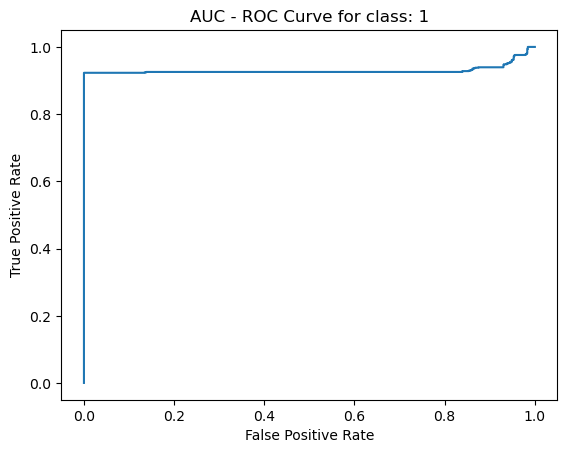

In [13]:
def AUC_ROC(y_true, y_pred_proba, class_ind=1):
    # y_true1, y_pred_proba_1 = list(zip(*list(sorted(zip(y_true, y_pred_proba), key = lambda x : x[1]))))
    sorted_indices = np.argsort(y_pred_proba)[::-1]
    sorted_y_true = y_true[sorted_indices]
    sorted_y_pred = y_pred_proba[sorted_indices]
    otv_list_y = []
    otv_list_x = []
    flag_y = 0
    flag_x = 0
    for y in sorted_y_true:
        if y == 1:
            flag_y+=1
        else:
            flag_x += 1
        otv_list_y.append(flag_y)
        otv_list_x.append(flag_x)

    otv_list_x = np.array(otv_list_x)
    otv_list_y = np.array(otv_list_y)
    plt.plot(otv_list_x/otv_list_x[-1], otv_list_y/otv_list_y[-1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'AUC - ROC Curve for class: {class_ind}')
    plt.show()

AUC_ROC(y_test1, otv[:,1])